In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print(f"TensorFlow version: {tf.__version__}")
print(f"Running from: {sys.executable}")

TensorFlow version: 2.20.0
Running from: c:\capstone_project_unfc\env\Scripts\python.exe


In [ ]:
# 1. SETUP PATHS
CURRENT_DIR = Path.cwd()
# Adjust REPO_ROOT to your local machine path (e.g., C:\capstone_project_unfc)
REPO_ROOT = CURRENT_DIR.parent.parent 

# 2. FETCH DATA
SYMBOL = "TSLA"
INTERVAL = "1wk"
PERIOD = "5y"

print(f"Fetching data for {SYMBOL}...")
df = yf.download(tickers=SYMBOL, period=PERIOD, interval=INTERVAL)
df = df.reset_index().rename(columns={"Date":"timestamp", "Close":"close"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# Create clean series for forecasting
prices = df.set_index("timestamp")["close"].astype(float).dropna()

print(f"Loaded {len(prices)} rows. Latest date: {prices.index.max()}")

prices.head()

prices.plot(title=f"{SYMBOL} Close Price", figsize=(10,4))
plt.show()


NameError: name 'Path' is not defined

In [15]:
# Configuration
TEST_SIZE = 30
LOOKBACK = 20
EPOCHS = 20
BATCH = 16

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices.values.reshape(-1, 1))

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

In [17]:
results = []
split_idx = len(prices) - TEST_SIZE

print(f"Starting Walk-Forward Backtest for {TEST_SIZE} periods...")

for i in range(split_idx, len(prices)):
    # Slice data for the current training window
    current_train = scaled_data[:i]
    X_train, y_train = create_sequences(current_train, LOOKBACK)
    
    # Build Model Architecture
    model = Sequential([
        LSTM(50, return_sequences=False, input_shape=(LOOKBACK, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)
    
    # Forecast 1-step ahead
    last_window = current_train[-LOOKBACK:].reshape(1, LOOKBACK, 1)
    pred_scaled = model.predict(last_window, verbose=0)
    yhat = float(scaler.inverse_transform(pred_scaled)[0, 0])
    
    results.append({
        "timestamp": prices.index[i],
        "y_true": float(prices.iloc[i,0]),
        "y_pred": yhat
    })

# Create result DataFrame
lstm_results = pd.DataFrame(results).set_index("timestamp")
print("✅ Backtest Complete.")

Starting Walk-Forward Backtest for 30 periods...


c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`

c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`

✅ Backtest Complete.



Final Metrics: {'MAE': np.float64(31.24019775390625), 'RMSE': 40.35267127650548, 'MAPE_%': np.float64(7.515826535641046)}


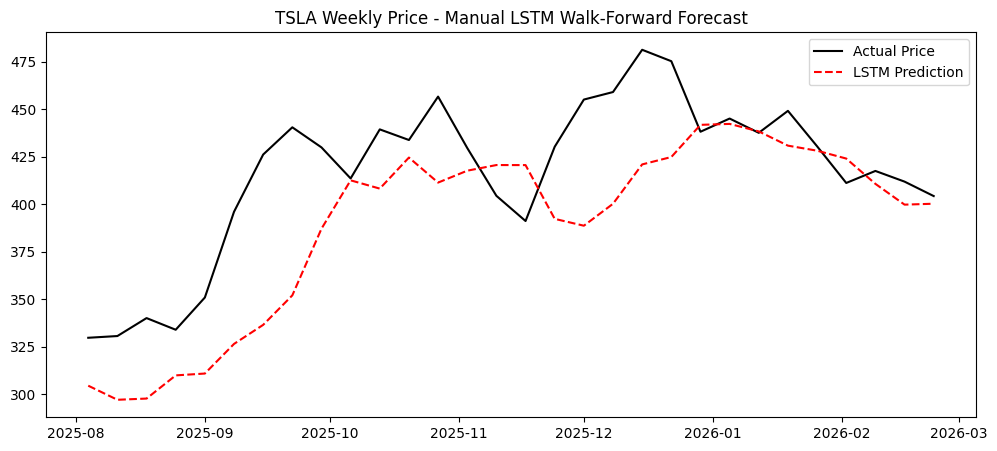

In [18]:
def get_metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

print("\nFinal Metrics:", get_metrics(lstm_results))

plt.figure(figsize=(12, 5))
plt.plot(lstm_results.index, lstm_results["y_true"], label="Actual Price", color='black')
plt.plot(lstm_results.index, lstm_results["y_pred"], label="LSTM Prediction", color='red', linestyle='--')
plt.title(f"{SYMBOL} Weekly Price - Manual LSTM Walk-Forward Forecast")
plt.legend()
plt.show()

In [19]:
# Path setup
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

lstm_path = OUTDIR / "pred_lstm_weekly_price.parquet"

# Ensure timestamp is datetime before saving
lstm_to_save = lstm_results.reset_index()
lstm_to_save["timestamp"] = pd.to_datetime(lstm_to_save["timestamp"])

lstm_to_save.to_parquet(lstm_path, index=False)

print(f"LSTM predictions saved to: {lstm_path}")

LSTM predictions saved to: c:\capstone_project_unfc\model\notebooks\artifacts\pred_lstm_weekly_price.parquet
